<a href="https://colab.research.google.com/github/dovalhugo/avitos-data-mining/blob/main/HugoDoVal_Trab_Final_Mineracao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise exploratória dos dados textuais da plataforma Avito

Avito é um site de classificados que oferece diversos tipos de mercadorias, empregos e serviços. É o maior site do gênero da Russia e ocupa a posição de terceiro maior do mundo. Apesar disso, um problema recorrente é a frustação de vendedores que investem em marketing, mas não tem o retorno esperado.

Na plataforma Avito, é comum encontrar vendedores decepcionais com uma demanda muito pequena, geralmente indicando que algo está errado com o produto ou com o anúncio, ou uma demanda muito grande, o que indica que um item muito bom e bem anunciado estava com o preço muito baixo.

O objetivo deste relatório, portanto, é prever a demanda de um anúncio de produto com base na sua descrição textural, que envolve parâmetros diferenciados de data, geolocalização e descrições do produto. Devido a maior complexidade de uma análise envolvendo as imagens, nesta análise será considerado apenas a existência ou não de uma imagem em um anúncio.

**Grupo/Aluno:** Hugo do Val Freire Fernandes  
**Curso:** Graduação em Ciência da Computação  
**DRE:** 111180076

In [ ]:
%matplotlib inline
import numpy as np
import random
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats, integrate
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

## Carregando o dataset
Apenas 3 arquivos dos diversos fornecidos pela Avito foram utilizados nesta análise.

* **train.csv**: Contém os dados de treino principais
* **test.csv**: Dataset de testes para avaliação final
* **periods_train.csv**: Dataset que contém as datas de início e término de um anúncio.

Os datasets foram carregados utilizando o Pandas, lendo o csv para um DataFrame.




In [ ]:
#Carregando o dataset em um dataframe do pandas
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
df_periods_train = pd.read_csv('periods_train.csv')

## Preparando os dados
O dataset foi reorganizado da maneira que se julgou melhor para a análise deste trabalho.

A coluna *image* foi transformada em um coluna booleana, a qual informa apenas se o anúncio tinha ou não uma imagem alocada, já que o código do arquivo jpg (como descrito no desafio da Avito) foi dado como irrelevante para a análise.

A coluna *param_3* foi completamente removida, pois 57,37% de suas entradas eram nulas e adotou-se o critério de remoção de qualquer coluna com mais de 50% de entradas nulas.

As colunas *param_1* e *param_2* foram inicialmente combinadas, dado ao alto índice de entrada nulas na coluna *param_2*. Contudo, ambas foram descartadas, pois não se encontrou uso para elas no escopo desta análise

Todas as colunas referentes a datas tiverem seu formato convertido de *string* para *datetime* para melhor manipulação desses dados. Desta forma criou-se a coluna *periods* que indica o período, em dias, decorrido do início ao fim do anúncio.

Finalmente, à guisa de melhor visualização, as categorias principais (*parent_category_name*) foram traduzidas livrimente, com auxílio do google tradutor, para o português.

In [ ]:
# Adicionando descrição textual vazia para entradas com descrição nula.
df_train['description'] = df_train['description'].fillna(" ")

# Adicionando coluna que diz se tem ou não imagem e removendo as colunas image
df_train['HasImage'] = np.where(df_train['image'].notnull(), 1, 0)
df_train = df_train.drop(['image'], axis=1)

# Deletando a coluna param_3, pois 57,37% de seus valores são nulos (Critério escolhido: mais de 50%)
df_train = df_train.drop(['param_3'], axis=1)

# Combinando param_1 e param_2
df_train['params'] = df_train['param_1'].map(str) + ' '+ df_train['param_2']
df_train['params'] = df_train['params'].fillna(" ")
df_train = df_train.drop(['param_1', 'param_2'], axis=1)

# Transformando as datas de String para datetime
df_train['activation_date'] = pd.to_datetime(df_train['activation_date'])
df_periods_train['activation_date'] = pd.to_datetime(df_periods_train['activation_date'])
df_periods_train['date_to'] = pd.to_datetime(df_periods_train['date_to'])
df_periods_train['date_from'] = pd.to_datetime(df_periods_train['date_from'])

# Contando os dias entre o tempo de início do anúncio até ser retirado
df_periods_train['period'] = df_periods_train['date_to'] - df_periods_train['date_from']

#Traduzindo as categorias e subcategorias (Google Tradutor)
translated_categories = {"Личные вещи" : "Coisas pessoais",
                            "Для дома и дачи" : "Casa e jardim",
                            "Бытовая электроника" : "Eletrônicos de consumo",
                            "Недвижимость" : "Imobiliária",
                            "Хобби и отдых" : "Hobbies e Lazer",
                            "Транспорт" : "Transporte",
                            "Услуги" : "Serviços",
                            "Животные" : "Animais",
                            "Для бизнеса" : "Negócios"}

df_train['parent_category_name_pt'] = df_train['parent_category_name'].apply(lambda x : translated_categories[x])

## Categorias principais por número de anúncios

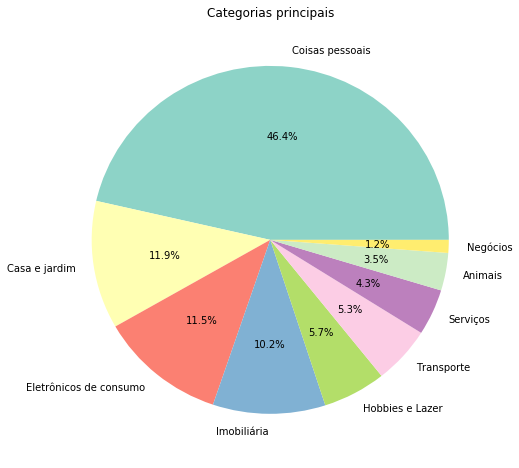

In [ ]:
# Visualização das categorias principais em porcentagem.
df_train['parent_category_name_pt'].value_counts().plot(colormap = 'Set3', autopct='%1.1f%%', title='Categorias principais', kind='pie', figsize=(8, 8))
plt.axis('off');

## Top 10 Regiões russas por número de anúncios

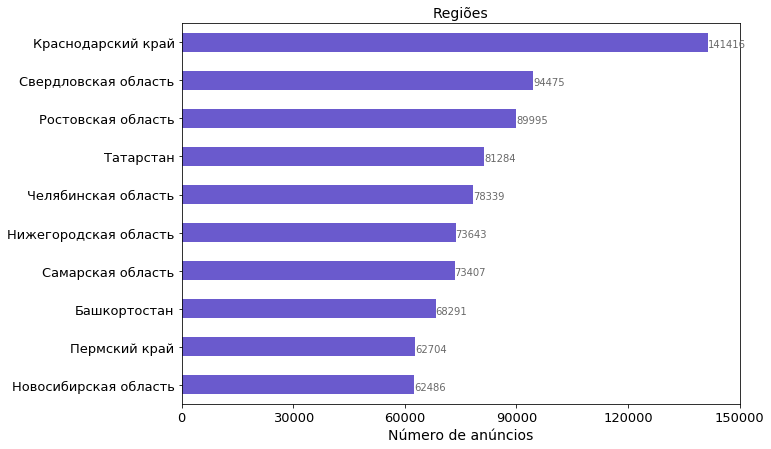

In [ ]:
#Mostrando um gráfico de barras das regiões da Russia de acordo com o número de anúncios

ax = df_train['region'].value_counts().head(10).plot(color = 'slateblue', kind='barh', figsize=(10, 7), fontsize=13)
ax.set_title("Regiões", fontsize=14)
ax.set_xlabel("Número de anúncios", fontsize=14);
ax.set_xticks([0, 30000, 60000, 90000, 120000, 150000])

totals = []

# Busca os valores de cada entrada para criar uma lista de valores
for i in ax.patches:
    totals.append(i.get_width())    

total = sum(totals)
for i in ax.patches:    
    ax.text(i.get_width()+.3, i.get_y()+.38, str(round((i.get_width()))), fontsize=10, color='grey')

# Apenas para plotar o gráfico com o maior número em cima
ax.invert_yaxis();

## Distribuição da chance de negócio (Deal Probability)
Variável alvo do treinamento

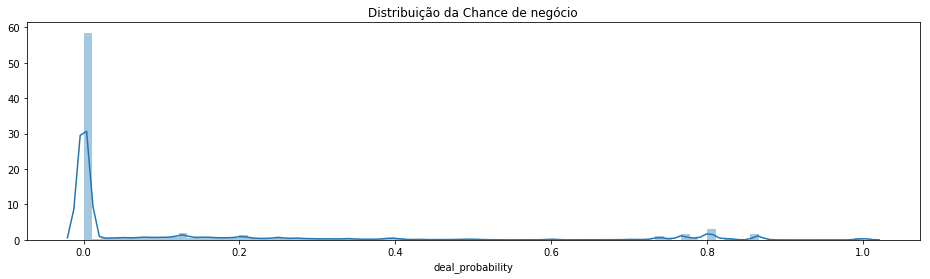

In [ ]:
#Mostrando a distribuição da Deal Probability
x=df_train['deal_probability']
plt.figure(figsize=(16,4))
plt.title("Distribuição da Chance de negócio", fontsize=12);
sns.distplot(x, bins=90);

Observando a distribuição é possível notar que a maioria dos anúncios tem uma probabilidade muito baixa de serem vendidos (barra próximo de 0.0), enquanto existe uma pequena quantidade de valores bastante discrepantes, que remetem a anúncios com grandes chandes de serem concluídos com sucesso.

In [ ]:
df_periods_train['period'].mean()
df_periods_train['period'].std();

## Duração dos anúncios

**Média de dias:** 8

**Desvio padrão de dias:** 4

**Maior tempo:** 13

**Menor tempo:** 0 (retirado no mesmo dia em que foi colocado)

## Preço
**Media:** 316708,09 RUB 

**Desvio padrão:** 64964794,61 RUB 

**Maior preço:** 79501011850,00 RUB 

**Menor preço:** 0,00 RUB 

O desvio padrão tão alto e maior que a média indica que a maioria dos preços está muito distante do valor da média, mostrando como estão espalhados. Portanto, os preço foram log-transformados para exibir valores mais aproximados e ainda sim permitir observar uma distribuição no histograma abaixo.



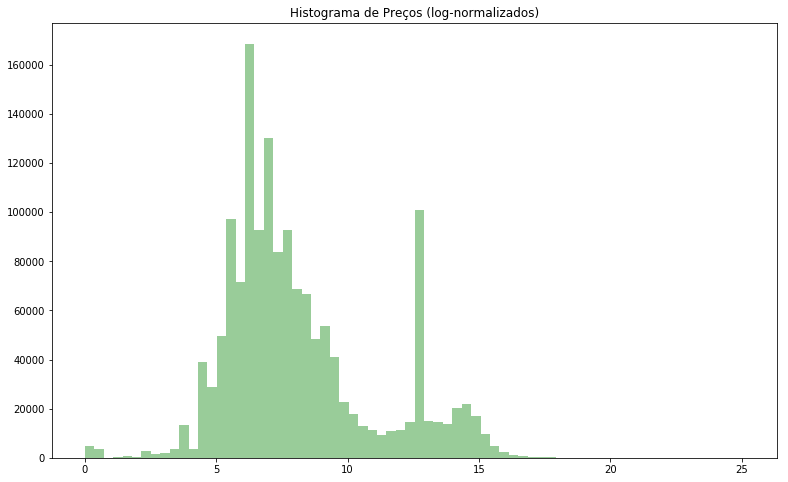

In [ ]:
df_train["price_induced"] = df_train["price"].values
df_train["price_induced"].fillna(np.nanmean(df_train["price"].values), inplace=True)

df_test["price_induced"] = df_test["price"].values
df_test["price_induced"].fillna(np.nanmean(df_test["price"].values), inplace=True)

plt.figure(figsize=(13,8))
sns.distplot(np.log1p(df_train["price_induced"].values), bins=70, kde=False, color="green")
plt.title("Histograma de Preços (log-normalizados)", fontsize=12)
plt.show()

## Configurando o modelo de treinamento

##### Feature Hashing

A maioria dos métodos de aprendizado de máquina lida com valores numéricos. Portanto, foi necessário adaptar mais ainda o dataset para poder fazer um treinamento adequado. Optou-se por um método conhecido como *Feature Hashing*, que consiste em em converter todos os dados almejados para o treinamento em um vetor de *features*

##### Train/Test split para validação
Foi utilizado um método do *scikitlearn* para dividir o *df_train* em um dataset com 20% do tamanho para validação posterior (mais rápido de testar).

##### Escolhendo as *features* desejadas
Uma das partes mais demoradas, converter todas as features escolhidas em vetores para que deixassem de ser textuais. A coluna de preço também foi log-transformada definitivamente para não gerar resultados discrepantes.


**OBS:** Os modelos foram separados em células diferentes para motivos de testes, devido a demora que era converter cada um quando necessário (correção de erros/testes)

In [ ]:
# Calcula um hash numérico para uma string qualquer recebida
def n_hash(s):
    random.seed(hash(s))
    return random.random()

# Transforma em um vector (hashing) uma coluna de um dataframe pandas   
def hash_column (row, col):
    if col in row:
        return n_hash(row[col])
    return n_hash('none')
#
train, validate = train_test_split(df_train, test_size=0.2)
    
# Feature Hashing nas features consideradas relevantes (Categóricas)  

# DataFrame de treinado após split (80% do original)
train['user_hash'] = train.apply (lambda row: hash_column (row, 'user_id'),axis=1)
train['region_hash'] = train.apply (lambda row: hash_column (row, 'region'),axis=1)
train['city_hash'] = train.apply (lambda row: hash_column (row, 'city'),axis=1)
train['parent_category_name_hash'] = train.apply (lambda row: hash_column (row, 'parent_category_name'),axis=1)
train['category_name_hash'] = train.apply (lambda row: hash_column (row, 'category_name'),axis=1)
train['user_type_hash'] = train.apply (lambda row: hash_column (row, 'user_type'),axis=1)
train['price_induced'] = np.log(train['price_induced'])

# Dataframe de validação
validate['user_hash'] = validate.apply (lambda row: hash_column (row, 'user_id'),axis=1)
validate['region_hash'] = validate.apply (lambda row: hash_column (row, 'region'),axis=1)
validate['city_hash'] = validate.apply (lambda row: hash_column (row, 'city'),axis=1)
validate['parent_category_name_hash'] = validate.apply (lambda row: hash_column (row, 'parent_category_name'),axis=1)
validate['category_name_hash'] = validate.apply (lambda row: hash_column (row, 'category_name'),axis=1)
validate['user_type_hash'] = validate.apply (lambda row: hash_column (row, 'user_type'),axis=1)
validate['price_induced'] = np.log(validate['price_induced'])


In [ ]:
# Dataframe train completo
df_train['user_hash'] = df_train.apply (lambda row: hash_column (row, 'user_id'),axis=1)
df_train['region_hash'] = df_train.apply (lambda row: hash_column (row, 'region'),axis=1)
df_train['city_hash'] = df_train.apply (lambda row: hash_column (row, 'city'),axis=1)
df_train['parent_category_name_hash'] = df_train.apply (lambda row: hash_column (row, 'parent_category_name'),axis=1)
df_train['category_name_hash'] = df_train.apply (lambda row: hash_column (row, 'category_name'),axis=1)
df_train['user_type_hash'] = df_train.apply (lambda row: hash_column (row, 'user_type'),axis=1)
#df_train['price_induced'] = np.log(df_train['price_induced'])

# Dataframe test completo
df_test['user_hash'] = df_test.apply (lambda row: hash_column (row, 'user_id'),axis=1)
df_test['region_hash'] = df_test.apply (lambda row: hash_column (row, 'region'),axis=1)
df_test['city_hash'] = df_test.apply (lambda row: hash_column (row, 'city'),axis=1)
df_test['parent_category_name_hash'] = df_test.apply (lambda row: hash_column (row, 'parent_category_name'),axis=1)
df_test['category_name_hash'] = df_test.apply (lambda row: hash_column (row, 'category_name'),axis=1)
df_test['user_type_hash'] = df_test.apply (lambda row: hash_column (row, 'user_type'),axis=1)
#df_test['price_induced'] = np.log(df_test['price_induced'])
  

In [ ]:
df_train['price_induced'] = np.log(df_train['price_induced'])
df_test['price_induced'] = np.log(df_test['price_induced'])

## Método KFold de validação cruzada

O método de validação cruzada foi usado para avaliar alguns algoritmos escolhidos para o treinamento.  
Este método consiste em selecionar uma pedaço do dataset para treinamento e outro para validação. Divide-se então o dataset em um número K de partes iguais e escolhe aleatoriamente uma dessas partes. Realiza-se então um número K de experimentos de aprendizado, escolhendo um dos subconjuntos K a cada vez, testando-o contra as K-1 partes restantes. Este processo de recepete K vezes e então é encontrada a média.

In [ ]:
# Definição da matriz para usar no XGB e no KFold

#Validação K-Fold. Divide-se o dataset de validação (menor, para este propósito, por motivos de tempo e capacidade de CPU)
validate_Kf = validate.as_matrix(columns=['image_top_1', 'user_hash', 'price_induced', 'region_hash', 'city_hash', 'parent_category_name_hash', 'category_name_hash', 'user_type_hash', 'HasImage','deal_probability'])
test_final = df_test.as_matrix(columns=['image_top_1', 'user_hash', 'price_induced', 'region_hash', 'city_hash', 'parent_category_name_hash', 'category_name_hash', 'user_type_hash', 'HasImage'])
train_final = df_train.as_matrix(columns=['image_top_1', 'user_hash', 'price_induced', 'region_hash', 'city_hash', 'parent_category_name_hash', 'category_name_hash', 'user_type_hash', 'HasImage'])
  

## Modelo XGBoost

XGBoost é uma implementação do algoritmo conhecido como *gradient boosted trees*. Consta de um algoritmo de aprendizado supervisionado, que visa prever uma variável alvo ao combinar estimativas de grupos de modelos mais simples e menos potentes.

Ele foi testado com diversos parâmetros e o melhor resultado, dentro do tempo e do escopo do trabalho, se encontra abaixo.

In [ ]:
#Divisão do dataset, isolando a coluna target em Y
X = validate_Kf[:,0:9]
Y = validate_Kf[:,9]

# Modelo escolhido: XGBoost
model = xgb.XGBRegressor(n_estimators=400, learning_rate=0.05, gamma=0, subsample=0.5, colsample_bytree=1, max_depth=8)
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Precisão: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Precisão: 20.87% (0.52%)


## O que se entende por baixa precisão?
A natureza contínua da coluna alvo torna muito raro acertar com precisão absoluta a probabilidade de fechar um negócio. Os números da coluna deal_probability variam de 0 a 1, possuindo às vezes 4 ou mais casas decimas. Assim, acredito que o método KFold não da uma precisão tão alta quanto uma escolha categórica ou binária.

## Conclusão

Dado a extensão do dataset e o imenso número de features, apenas algumas foram escolhidas por terem uma natureza mias categória e aparentarem serem mais relevantes para a chance de negócio do anúncio. Acredita-se que o resultado é ligeiramente satisfatório para o escopo do trabalho, mas não para uma resposta ao desafio proposto. Considerando que os dados originais, completos, somam mais de 40 gigas de imagens e outros arquivos csv. O método KFold serviu para medir a relevância e precisão do experimento, bem como a regressão em XGBoost serviu para dar um resultado final para a avaliação.

Para uma futura continuação do experimento, seria interessante testar outros métodos e trabalhar melhor no *Feature Hashing* e manutenção do dataset. Diversas outras colunas poderiam ser utilizadas, principalmente em conjunto com os dados de períodos e de *train_active*/*test_active* fornecidos pela Avito.

In [ ]:
# Fit (treinamento)
model.fit(train_final, df_train['deal_probability'])

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

In [ ]:
# Predição final
predction = model.predict(test_final)
